In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
import os
import sys

sys.path.append('..')
from q_alchemy.qiskit import QAlchemyInitialize

os.environ["Q_ALCHEMY_API_KEY"] = "n6I5ypSXJeb8E1mlX71gAJ1v9RCKSb52"

algorithm_globals.random_seed = 12345

In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.u(params[0], params[1], params[2], 0)
    target.u(params[3], params[4], params[5], 1)
    target.cx(0, 1)
    target.ry(params[6], 0)
    target.rz(params[7], 1)
    target.cx(1, 0)
    target.ry(params[8], 0)
    target.cx(0, 1)
    target.u(params[9], params[10], params[11], 0)
    target.u(params[12], params[13], params[14], 1)
    return target

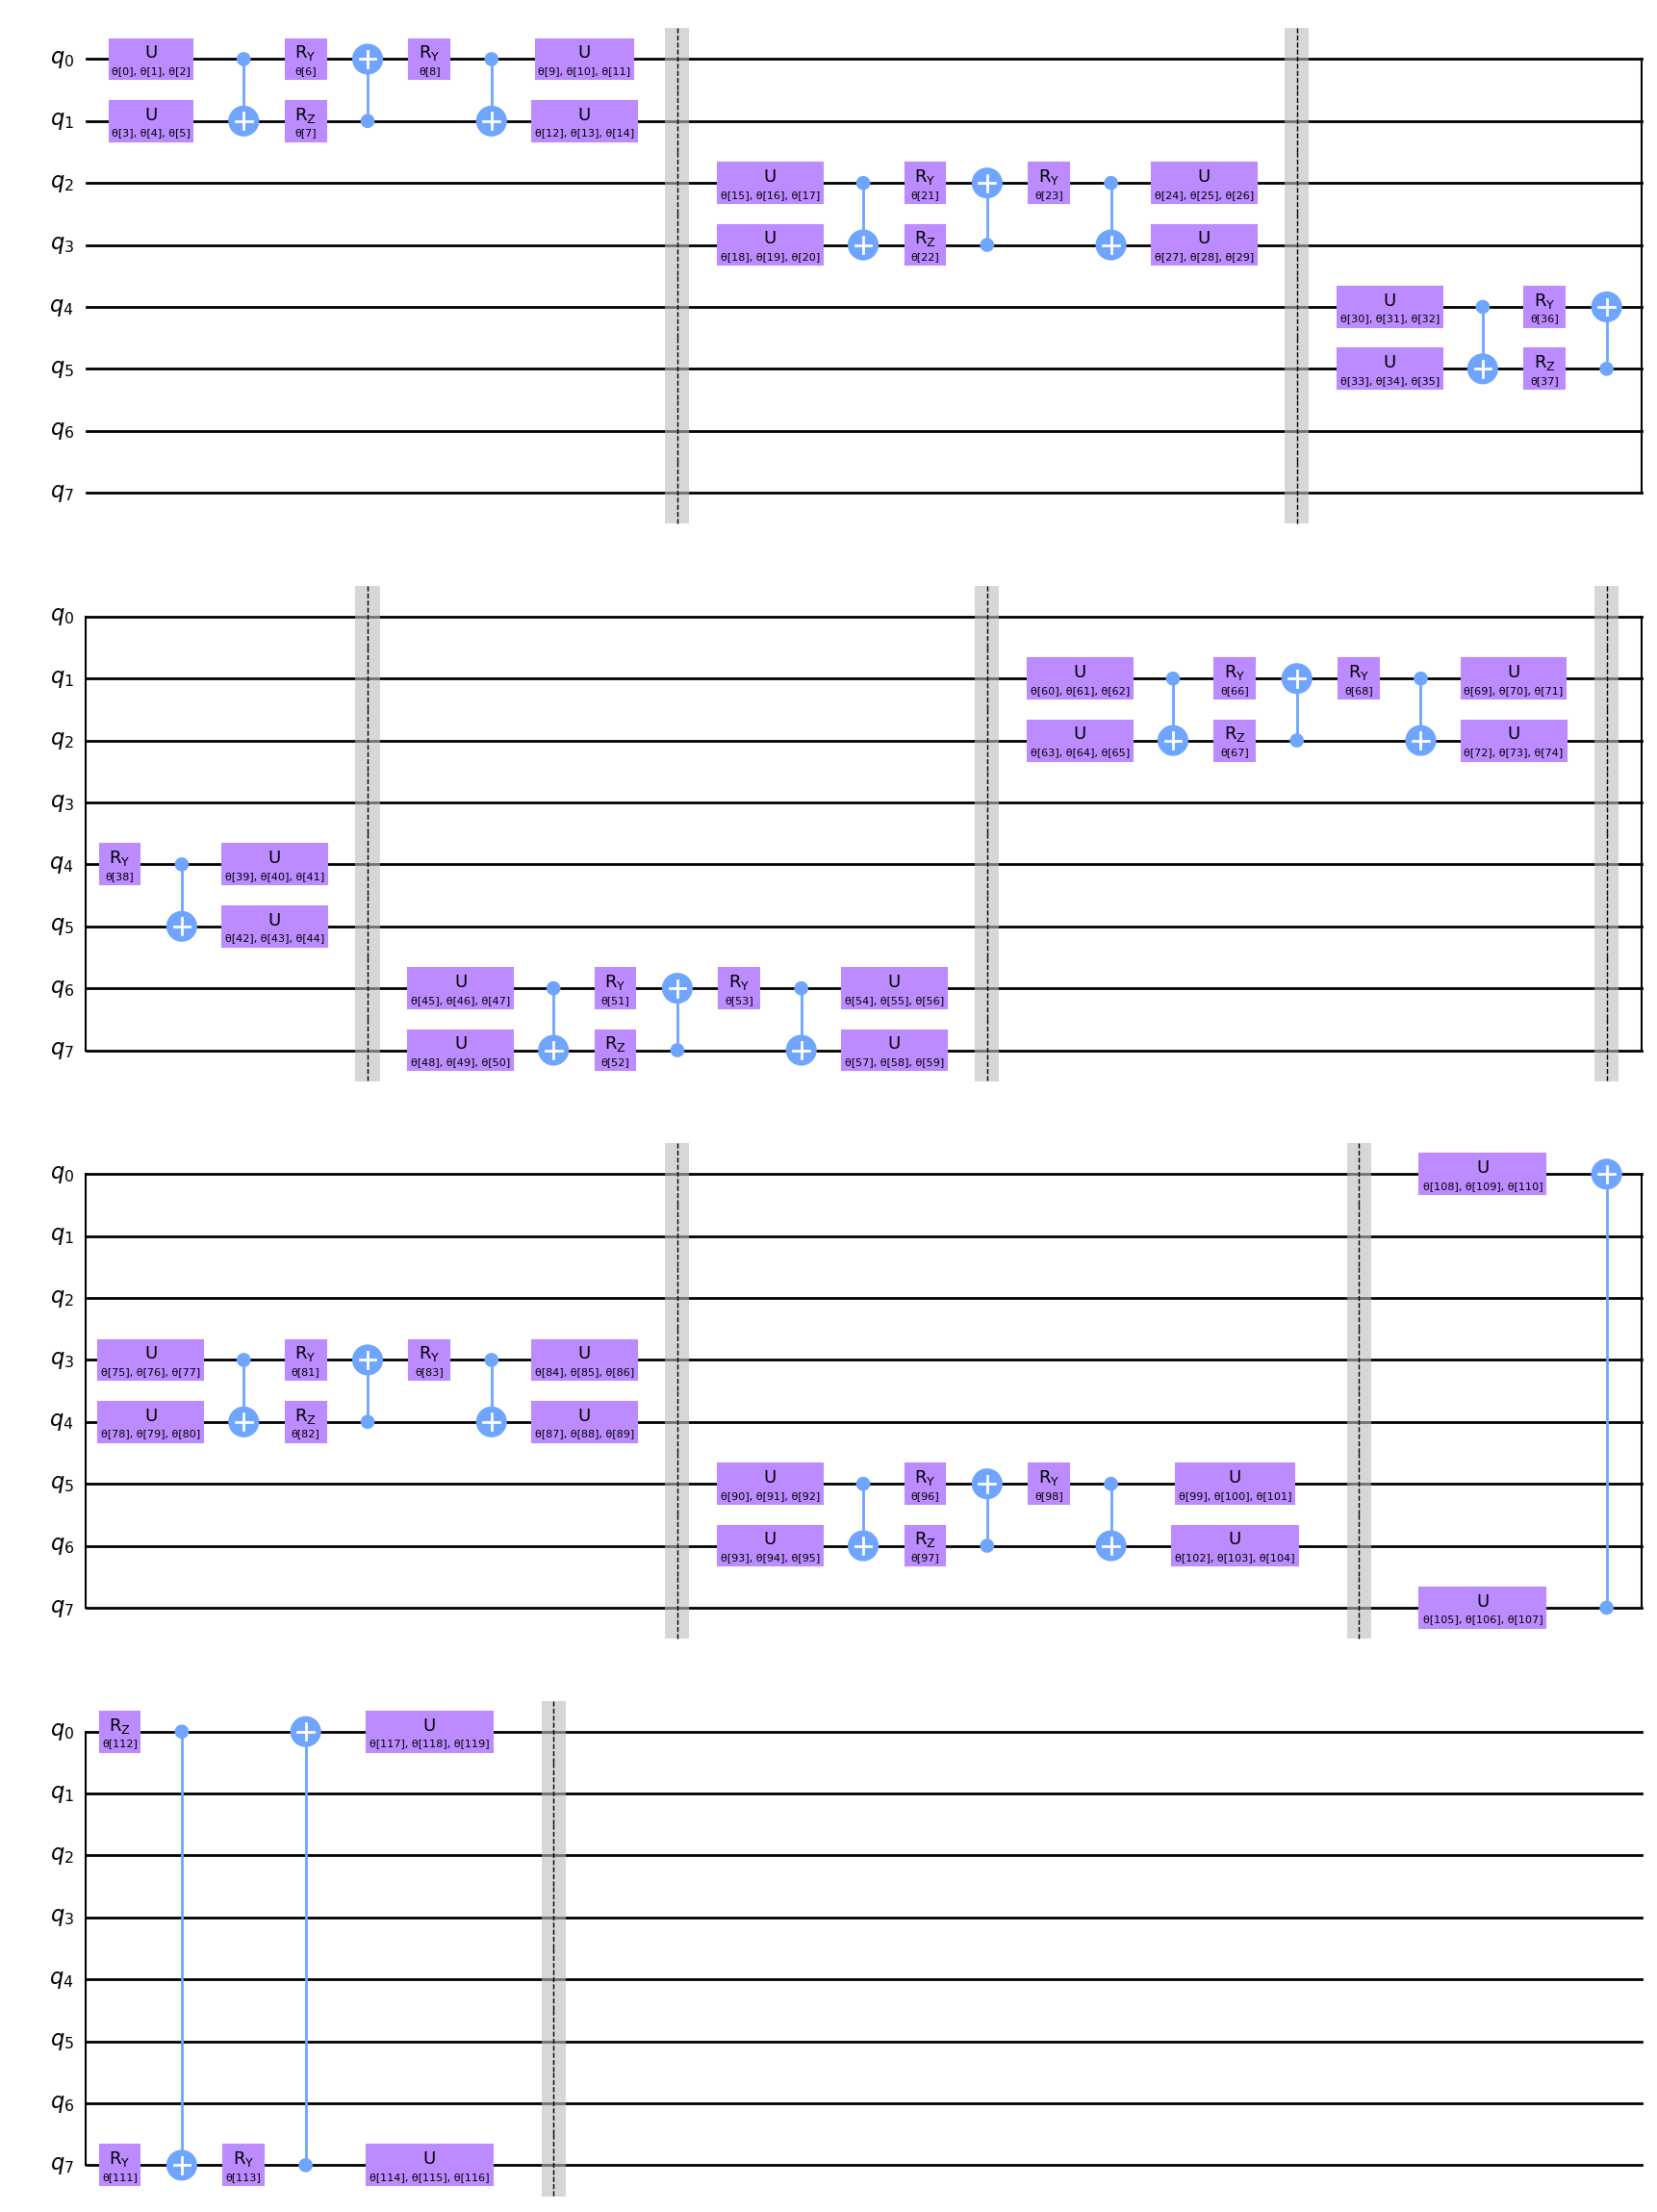

In [8]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

#arams = np.random.rand(15)
circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl")

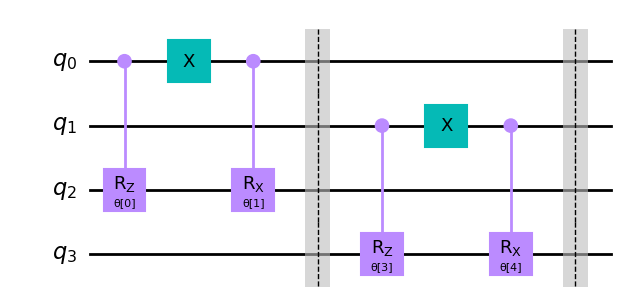

In [10]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.crz(params[0], 0, 1)
    target.x(0)
    target.crx(params[1], 0, 1)
    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Loading Mnist data

In [27]:
import tensorflow as tf
def load_minist01():
    classes = [0, 1]
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    
    x_train_filter_01 = np.where((y_train == classes[0]) | (y_train == classes[1]))
    x_test_filter_01 = np.where((y_test == classes[0]) | (y_test == classes[1]))

    X_train, X_test = x_train[x_train_filter_01], x_test[x_test_filter_01]
    Y_train, Y_test = y_train[x_train_filter_01], y_test[x_test_filter_01]
    
    Y_train = [1 if y == classes[0] else -1 for y in Y_train]
    Y_test = [1 if y == classes[0] else -1 for y in Y_test]
    
    X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
    X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
    X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()
    
    X_train_norms, X_test_norms = np.linalg.norm(X_train, axis=1), np.linalg.norm(X_test, axis=1)
    X_train_norms, X_test_norms = X_train_norms[:, np.newaxis], X_test_norms[:, np.newaxis]
    
    X_train, X_test = X_train/X_train_norms, X_test/X_test_norms
    
    return X_train, X_test, Y_train, Y_test

In [28]:
X_train, X_test, y_train, y_test = load_minist01()

In [29]:
def preparation_circuit(X):
    sp_org = QAlchemyInitialize(X, opt_params={'max_fidelity_loss':0.0})
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc

In [31]:
qc = preparation_circuit(X_train[0])

global phase: 4.4684
     ┌───────────────┐                ┌──────────────┐┌────────┐     ┌─────────────┐                                                                                                                                                                                                                                                                                                                        ┌─────────────┐ ┌────────────┐┌──────────────┐                                                                                                                                                 ┌───┐┌─────────────┐┌────────────┐ ┌────────────┐┌───┐┌────────────┐┌───────────┐  ┌────────────┐┌───┐┌─────────────┐┌───────────┐  ┌───────────┐ ┌───┐ ┌────────────┐ ┌────────────┐ ┌────────────┐ ┌───┐ ┌────────────┐ ┌────────────┐┌─────────────┐┌───┐┌─────────────┐┌────────────┐ ┌────────────┐ ┌───┐┌─────────────┐┌────────────┐ ┌────────────┐                                                                                                                                                                                                                                                                               ┌───┐ ┌────────────┐┌────────────┐┌─────────────┐ ┌───┐ ┌────────────┐┌────────────┐┌─────────────┐┌───┐┌──────────────┐┌────────────┐ ┌────────────┐┌───┐ ┌───────────┐  ┌────────────┐ ┌─────────────┐┌───┐┌─────────────┐┌────────────┐ ┌────────────┐┌───┐ ┌────────────┐┌────────────┐┌─────────────┐ ┌───┐┌──────────────┐┌────────────┐┌─────────────┐                                                                                                                                                                                                                                                                                                                                                              ┌─────────────┐  ┌────────────┐┌─────────────┐     ┌───┐      ┌────────────┐ ┌────────────┐ ┌─────────────┐     ┌───┐     ┌────────────┐┌────────────┐┌────────────┐    ┌───┐     ┌──────────────┐ ┌────────────┐┌─────────────┐    ┌───┐     ┌────────────┐ ┌────────────┐┌─────────────┐    ┌───┐     ┌─────────────┐ ┌────────────┐┌────────────┐     ┌───┐     ┌────────────┐┌────────────┐┌─────────────┐     ┌───┐      ┌───────────┐ ┌─────────────┐                                                                                                                ┌───┐┌───────────────┐┌─────────┐ ┌───┐  ┌─────────┐   ┌─────────────────┐┌───┐┌─────────────────┐     ┌───┐     ┌──────────────┐ ┌─────────┐     ┌───┐   ┌─────────┐┌───────────────┐     ┌───┐      ┌───────────────┐  ┌─────────┐     ┌───┐   ┌────────────────┐                                                            
q_0: ┤ Ry(0.0059072) ├───────■────────┤ Ry(-0.57034) ├┤ Rz(-π) ├──■──┤ Rz(0.74556) ├─────────────────■────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────■──┤ Rz(-1.5785) ├─┤ Ry(1.6895) ├┤ Rz(-0.12956) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(-1.0813) ├┤ Ry(1.4568) ├─┤ Rz(2.0199) ├┤ X ├┤ Rz(1.7053) ├┤ Ry(1.561) ├──┤ Rz(-1.425) ├┤ X ├┤ Rz(-1.3178) ├┤ Ry(1.541) ├──┤ Rz(1.804) ├─┤ X ├─┤ Rz(1.2989) ├─┤ Ry(1.5301) ├─┤ Rz(-1.866) ├─┤ X ├─┤ Rz(2.1954) ├─┤ Ry(1.7595) ├┤ Rz(-2.1412) ├┤ X ├┤ Rz(0.76625) ├┤ Ry(1.1678) ├─┤ Rz(-2.466) ├─┤ X ├┤ Rz(-1.7262) ├┤ Ry(1.9091) ├─┤ Rz(-1.685) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [32]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

def construct_circuit(X):
    state_prep = preparation_circuit(X)
    ansatz = QuantumCircuit(8, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

    # Third Pooling Layer
    ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QuantumCircuit(8)
    circuit.compose(state_prep, range(8), inplace=True)
    circuit.compose(ansatz, range(8), inplace=True)
    return circuit, ansatz

In [ ]:
def qcnn_estimator(X):
    circuit, ansatz = construct_circuit(X)
    qcnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    weight_params=ansatz.parameters,
    )
    return qcnn

In [ ]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qcnn_estimator(X),
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph
)